![logo.png](logo_smallest.png)

# Google Play Store Apps

**About**     
The key question focuses on predicting app installs using essential predictors. Various Supervised techniques are  utilized in this problem. 

**Data**       
Web Scrapper API is created in Python using Beautiful Soup library which scraps the data from Google Play Store. Webscraper API can be found at https://github.com/saxenasomil/data_science_projects/tree/master/2.%20Web_Scrapped_Apps_ML/webScraper

This API stores data in a CSV file (named apps_additional_info.csv which will be used as the source dataset.

This project will utilize three data sources:

1.  **apps_additional_info.csv** - This data file contains the additional information needed about 10000 apps present on Google Play Store.It has columns such as App, Interactive Elements, Permissions, Report, Offered By, Developer, In-app Products. The data was last scraped on 04/09/20.

Above data source is scraped using WebScrapper API.
Below source file is from Kaggle:

2.  **googleplaystore.csv** - This dataset file is contains info about 10000 apps. It has columns such as App, Category, Rating, Reviews, Size, Installs, Type, Price, Content Rating, Genres, Last Updated, Current Ver, Android Version.

**Assumptions**        
None 

**References**     
https://www.kaggle.com/lava18/google-play-store-apps

## Exploratory Data Analysis

### 1. Import Required Packages

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import time
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

### 2. Load Data

After loading and going for in-depth analysis, the head of the dataset is observed to get a glimpse of different variables.

In [2]:
# Load additional info from the csv generated post web scraping
store_apps_add_info = pd.read_csv('dataset/apps_additional_info.csv')

store_apps = pd.read_csv('dataset/googleplaystore.csv')
store_apps.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### 3. Merge Additional App Info with existing App Info

Additional Info about the apps is web scraped, the new info is merged with the existing info.

In [3]:
# Merge Offered By, Interactive Elements column with other information
store = pd.merge(store_apps, store_apps_add_info[['Offered By','Interactive Elements','In-app Products','App']],on='App',how='left')
store.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Offered By,Interactive Elements,In-app Products
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,NaN,NaN,NaN
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,NaN,NaN,NaN
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,NaN,NaN,NaN
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,NaN,NaN,NaN
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,KidsAppBox,NaN,NaN


### 3. Check for data dimensions

In [4]:
store.shape

(11403, 16)

The dataset contains 11403 rows and 16 columns

### 4. Check for abnormal data

In [5]:
store['Installs'].value_counts()

1,000,000+        1644
10,000,000+       1401
100,000+          1179
10,000+           1061
1,000+             916
5,000,000+         824
100+               725
500,000+           551
100,000,000+       528
50,000+            484
5,000+             477
10+                386
50,000,000+        345
500+               330
50+                205
500,000,000+        96
1,000,000,000+      86
5+                  82
1+                  67
0+                  14
Free                 1
0                    1
Name: Installs, dtype: int64

One strange thing to notice is that the column 'Installs' contains one strange entry 'Free'. 

In [6]:
store[store['Installs'] == 'Free']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Offered By,Interactive Elements,In-app Products
11028,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN,Life Made,Users Interact,NaN


In [7]:
store = store[store['Installs']!='Free']

This appears to be an data entry error, hence the row is removed from the dataframe

### 5. Check variable datatypes

In [8]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11402 entries, 0 to 11402
Data columns (total 16 columns):
App                     11402 non-null object
Category                11402 non-null object
Rating                  9925 non-null float64
Reviews                 11402 non-null object
Size                    11402 non-null object
Installs                11402 non-null object
Type                    11401 non-null object
Price                   11402 non-null object
Content Rating          11402 non-null object
Genres                  11402 non-null object
Last Updated            11402 non-null object
Current Ver             11394 non-null object
Android Ver             11400 non-null object
Offered By              6660 non-null object
Interactive Elements    2882 non-null object
In-app Products         2160 non-null object
dtypes: float64(1), object(15)
memory usage: 1.5+ MB


The datatype of certain variables needs to be fixed. 
* Variables such Type, Genres should be categorical variables as they have fixed amount of categories defined.
* Reviews, Size, Installs, Price should be converted to numeric

In [9]:
store["Type"] = store["Type"].astype('category')
store["Genres"] = store["Genres"].astype('category')

#Lets begin by making the installs column numeric, currently it ends with a '+' sign and has ',' to separate thousands.
store['Installs'] = store['Installs'].str.replace('+','')
store['Installs'] = store['Installs'].str.replace(',','')
store['Installs'].value_counts()
store['Installs'] = pd.to_numeric(store["Installs"])

#Lets begin by making the reviews column numeric
store["Reviews"] = pd.to_numeric(store["Reviews"])

#Replace $ and make Price column numeric
#Default currency is $
store['Price'] = store['Price'].str.replace('$','')
store["Price"] = pd.to_numeric(store["Price"])

store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11402 entries, 0 to 11402
Data columns (total 16 columns):
App                     11402 non-null object
Category                11402 non-null object
Rating                  9925 non-null float64
Reviews                 11402 non-null int64
Size                    11402 non-null object
Installs                11402 non-null int64
Type                    11401 non-null category
Price                   11402 non-null float64
Content Rating          11402 non-null object
Genres                  11402 non-null category
Last Updated            11402 non-null object
Current Ver             11394 non-null object
Android Ver             11400 non-null object
Offered By              6660 non-null object
Interactive Elements    2882 non-null object
In-app Products         2160 non-null object
dtypes: category(2), float64(2), int64(2), object(10)
memory usage: 1.3+ MB


### Functions

In [10]:
#Checking missing values : percentage
def computeMissingPercent(df):
    missing_values = (df.isnull().sum() / len(df) * 100)
    missdf = missing_values.to_frame()
    missdf.columns = ['Missing_Percent']
    return missdf

def checkAndRemoveDuplicates(df):
    duplicate_row_count = len(df[df.duplicated()])
    if duplicate_row_count == 0:
        return "No duplicates"
    else:
        store.drop_duplicates(keep=False,inplace=True) 
        return ("Dropped duplicates: " + str(duplicate_row_count))
    
def transfromByLabelEncoder(df, columnName):
    enc = preprocessing.LabelEncoder()
    df[columnName] = enc.fit_transform(store[columnName])
    return df

### 6. Check for missing values

In [11]:
computeMissingPercent(store).sort_values(by=['Missing_Percent'],ascending=False)

,Missing_Percent
In-app Products,81.055955
Interactive Elements,74.723733
Offered By,41.589195
Rating,12.953868
Current Ver,0.070163
Android Ver,0.017541
Type,0.008770
App,0.000000
Category,0.000000
Reviews,0.000000


In-app Products, Interactive Elements are having the more than 70% missing values. This high count of missing values cannot be imputed, hence we would drop these columns.

Rating is having a significant number of missing values. It can be either replaced by median or mean. To finalize on this, we would begin by plotting the distribution of rating.

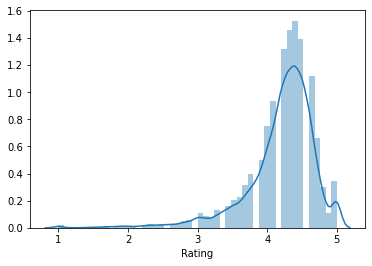

In [12]:
# Drop the columns with large number of missing values
store = store.drop(['Interactive Elements','In-app Products'],axis=1)

nonNullRatings = store[store['Rating'].notnull()]
sns.distplot(nonNullRatings['Rating'])

The distribution is skewed to the right. So Median will be the best way to impute missing values.

In [13]:
store['Rating'] = store['Rating'].fillna(store['Rating'].median())

Fill the missing values in 'Offered By' with the value 'Others'. 

In [14]:
store['Offered By'] = store['Offered By'].fillna('Others')

In [15]:
computeMissingPercent(store).sort_values(by=['Missing_Percent'],ascending=False)

,Missing_Percent
Current Ver,0.070163
Android Ver,0.017541
Type,0.008770
App,0.000000
Category,0.000000
Rating,0.000000
Reviews,0.000000
Size,0.000000
Installs,0.000000
Price,0.000000


Remove rows having Null Values as percentage of missing values for these columns is very small.
Since CurrentVer, AndroidVer and Type are have missing values less than 0.1% , associated rows are dropped from the dataset.

In [16]:
store = store.dropna()

### 8. Check for duplicates

Lets have a look at the duplicates present in the data.

In [17]:
#View duplicate records
duplicate_df = store[store.duplicated()]
duplicate_df[duplicate_df['App']=='CBS Sports App - Scores, News, Stats & Watch Live'].head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Offered By
3239,"CBS Sports App - Scores, News, Stats & Watch Live",SPORTS,4.3,91031,Varies with device,5000000,Free,0.0,Everyone,Sports,"August 4, 2018",Varies with device,5.0 and up,"CBS Interactive, Inc."
3273,"CBS Sports App - Scores, News, Stats & Watch Live",SPORTS,4.3,91031,Varies with device,5000000,Free,0.0,Everyone,Sports,"August 4, 2018",Varies with device,5.0 and up,"CBS Interactive, Inc."
3274,"CBS Sports App - Scores, News, Stats & Watch Live",SPORTS,4.3,91031,Varies with device,5000000,Free,0.0,Everyone,Sports,"August 4, 2018",Varies with device,5.0 and up,"CBS Interactive, Inc."


Duplicates will be checked and if found, they would be removed from the dataset

In [18]:
#Remove duplicates
checkAndRemoveDuplicates(store)

'Dropped duplicates: 1041'

## Data Visualization

### 1. Average Installs per Category

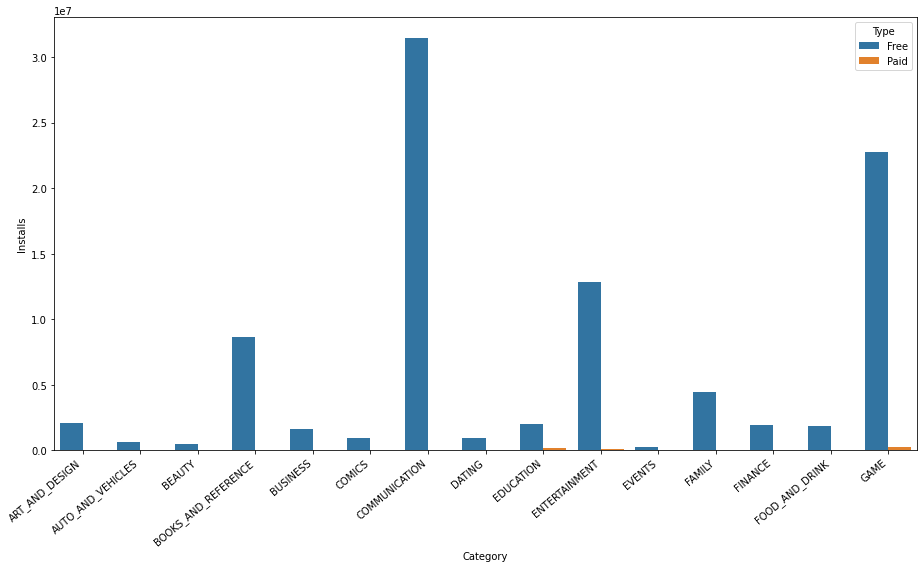

In [19]:
avg_rat_by_category = store.groupby(['Category','Type']).agg({'Installs':'mean'})
avg_rat_by_category = avg_rat_by_category.reset_index()
plt.figure(figsize=(13,8))
ax = sns.barplot(x="Category", y="Installs",hue="Type", data=avg_rat_by_category[:30])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

As expected, the average installs is highest for 'Communication' Category followed by "GAME" in the Free category. Reason is mainly communication category has various social media apps.

Average Installs of Paid Apps is significantly low in all categories.

### 2.  Average Price Per Category

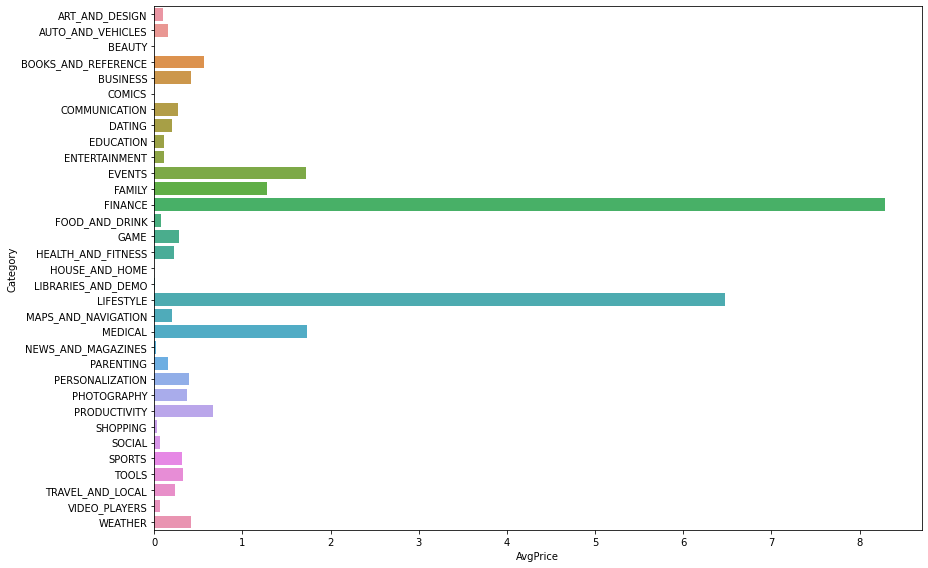

In [20]:
avgPricePerCategory = store.groupby('Category').agg(AvgPrice = ('Price','mean')).reset_index()
plt.figure(figsize=(13,8))
ax = sns.barplot(y="Category", x="AvgPrice", data=avgPricePerCategory)
plt.tight_layout()
plt.show()

Finance Category has the highest avg. price of approximately $8 which is quite high. Since Apps pertaining to such Category are official apps of various financial institutions such as stock market apps, etc.

### 3. WordCloud : Genre

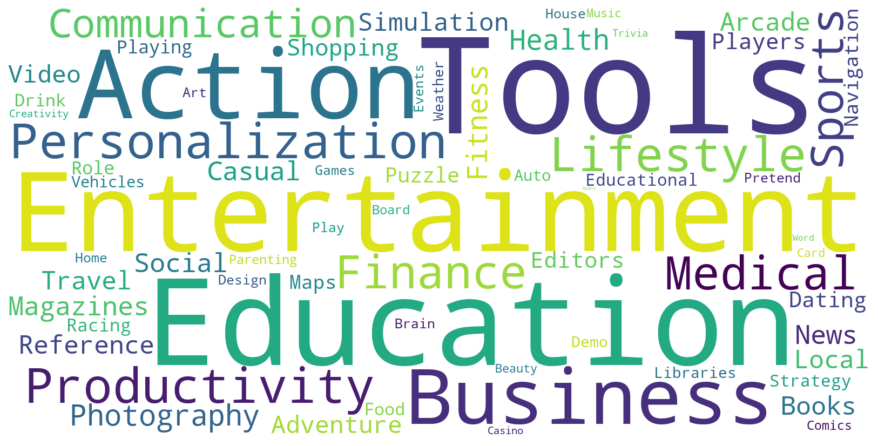

In [21]:
wordcloud1 = WordCloud(max_font_size=250, collocations=False, max_words=100, width=1600, height=800, background_color="white").generate(' '.join(store['Genres'].astype(str)))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

This shows that the genre,"Tools" dominate the market which is followed by Entertainment

### 4. App Count Per Category

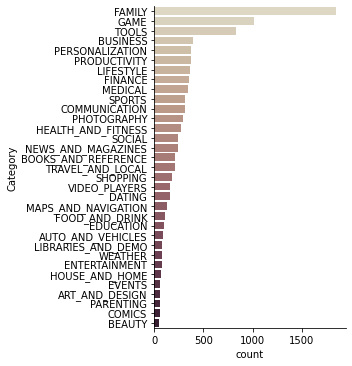

In [22]:
sns.catplot(y="Category", kind="count", palette="ch:.35",order = store['Category'].value_counts().index, data=store)

As expected the play store market is dominated by apps in Family category since they are not targeted for specific age group and utilized by a larger audience, such kinds of apps are the favourite choice of various app developers.

### 5. Apps by Installs

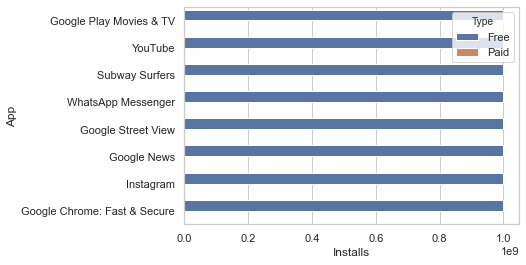

In [23]:
sns.set(style="whitegrid")
sns.barplot(x="Installs", y="App",hue="Type", data=store.sort_values(by='Installs',ascending=False)[:10])

Above plot shows the top ten apps in terms of Installs,

Google Play Movies, Youtube, Whatsapp,Chrome etc. has installs more than 1,000,000,000. In Games, Subway Surfers leads the other games

### 6. Company with Most Apps

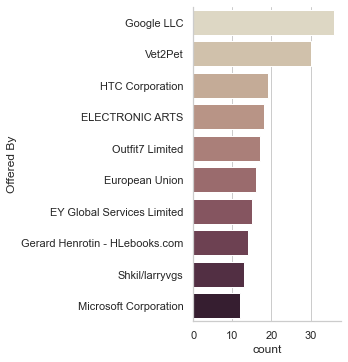

In [24]:
sns.catplot(y="Offered By", kind="count", palette="ch:.35",order = store['Offered By'].value_counts().index[1:11], data=store)

Google LLC dominates the Play Store market in terms of the number of apps offered by single company/developer in this dataset.

## Data Preprocessing (Cleaning and Feature Engineering)

### 1. Clean numerical and unicode characters from Current Ver

In [25]:
# Replace unicode characters like registered trademark, dash, tilde on alphabets, etc. Example - this entry : 3.1020180–00130
replacements = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for r in replacements:
     store['Current Ver'] = store['Current Ver'].astype(str).apply(lambda x : x.replace(r, ''))

# Remove any characters such as alphabets, special symbols, eg. this entry: 'Varies with device' and convert them into 0
regexStrings = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for reg in regexStrings:
    store['Current Ver'] = store['Current Ver'].astype(str).apply(lambda x : re.sub(reg, '0', x))

#Removing multiple . and bringing it to down to a single . : converting to numeric eg. 10.7.8.111 converts to 10.78111
store['Current Ver'] = store['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)

### 2. Transforming categorical variables to dummy variables

Dummy Encoding is done for the Category variable. Other categorical variables are transformed using LabelEncoder

In [26]:
unique_categories = store['Category'].unique().tolist()
store = pd.concat([store, pd.get_dummies(store['Category'])], axis=1)

cat_variables = ['App','Content Rating', 'Genres','Type','Offered By']
for col in cat_variables:
    store = transfromByLabelEncoder(store,col)

### 3. Convert Last Updated to a floating point number, for compatibility with time()

In [27]:
store['Last Updated'] = store['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

### 4. Convert App Size column to a common scale of Megabytes(M)

In [28]:
kilo_indices = store['Size'].loc[store['Size'].str.contains('k')].index.tolist()

# Strip k suffix from size and convert into M
stripKdf = pd.DataFrame(store.loc[kilo_indices, 'Size'].apply(lambda s: s.strip('k')).astype(float))
dfToMsize = stripKdf.apply(lambda s: s / 1024)
roundSizeDf = dfToMsize.apply(lambda s: round(s, 3)).astype(str)
store.loc[kilo_indices,'Size'] = roundSizeDf

# Strip M suffix from size and for device
store['Size'] = store['Size'].apply(lambda s: s.strip('M'))

In [29]:
# Replace 'Varies with device' with average size by category
varies_indices = store[store['Size'] == 'Varies with device'].index.tolist()
store.loc[varies_indices,'Size'] = 0
store['Size'] = store['Size'].astype(float)

aggSizePerCategory = store.groupby('Category').agg(AvgSize = ('Size','mean')).reset_index()

def replaceEmptyWithAvgCategorySize(x):
    temp = aggSizePerCategory
    if x['Size'] == 0:
        record = temp[temp['Category'] == x['Category']]
        x['Size'] = np.round(np.array(record['AvgSize'])[0],1)
    return x

store = store.apply(replaceEmptyWithAvgCategorySize,axis=1)

## Model Development

### Scaling the features and Train/Test Split

In [30]:
features = ['App', 'Reviews', 'Size', 'Rating', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver','Offered By']
features.extend(unique_categories)

X = preprocessing.StandardScaler().fit_transform(store[features])
y = store['Installs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=127)

model_with_scores = {}

### Linear Model

#### 1. Linear Regressor

In [31]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
pred = model.predict(X_test)
model_with_scores.update(LinearRegression = model.score(X_test, y_test))
model.score(X_test, y_test)

0.507879296368204

Linear Regressor performed poorly on this dataset with an r square of just 0.5

#### 2. Lasso Regressor

In [32]:
model = Lasso(alpha=100,normalize=True, max_iter=1000)
model.fit(X_train, y_train)
pred = model.predict(X_test)
model_with_scores.update(LassoRegressor = model.score(X_test, y_test))
model.score(X_test, y_test)

0.5079354977377809

Lasso Regressor performed poorly on this dataset with an r square of just 0.5. Thus linear models are not effective and we would switch to non-linear models.

#### Hyper Parameter Tuning

In [33]:
from warnings import filterwarnings
filterwarnings('ignore')

lambdas=list(range(1,101))
params={'alpha':lambdas}
grid_search=GridSearchCV(model,param_grid=params,cv=10,scoring='neg_mean_absolute_error')
grid_search.fit(X_train,y_train)
grid_search.best_estimator_

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

Hyperparameter Tuning suggests that optimum value of aplha should be 100 and the optimum value of max_iter should be 1000

### Non Linear Model

#### 1. K Nearest Neighbors

In [34]:
model = KNeighborsRegressor(n_neighbors=4)
model.fit(X_train,y_train)
pred = model.predict(X_test)
model_with_scores.update(K_NearestNeighbors = model.score(X_test, y_test))
model.score(X_test, y_test)

0.5470164749643404

This model performed better than linear models, but not quite significantly.

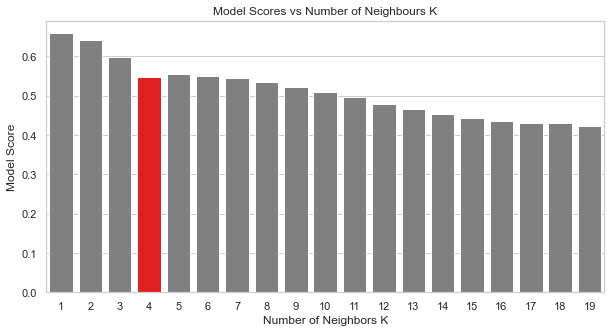

In [35]:
n_neighbors = list(range(1,20))
model_scores = []

for i in n_neighbors:
    model.set_params(n_neighbors = i)
    model.fit(X_train, y_train)
    model_scores.append(model.score(X_test, y_test))

#Plot the graph    
plt.figure(figsize=(10, 5))
plt.title("Model Scores vs Number of Neighbours K")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Model Score")
clrs = ['grey' if (x !=4 ) else 'red' for x in n_neighbors ]
sns.barplot(n_neighbors, model_scores, palette=clrs)

The plot shows the model accuracy will decrease as the number of K increases from 1 to 20. At K = 4,the model score/accuracy is good.
- Accuracy with K = 4 neighbors => 0.5470

From K=5 to K=20, model accuracy decreases and in a uniform manner,thus K=4 is the optimum hyperparameter value for number of neighbors.

#### 2. Random Forest Regressor

In [36]:
model = RandomForestRegressor(n_estimators = 100, random_state=127)
model.fit(X_train,y_train)
pred = model.predict(X_test)
model_with_scores.update( RandomForest = model.score(X_test, y_test))
model.score(X_test, y_test)

0.8008923132611843

This model performed much better than previous models with accuracy close to 80%.

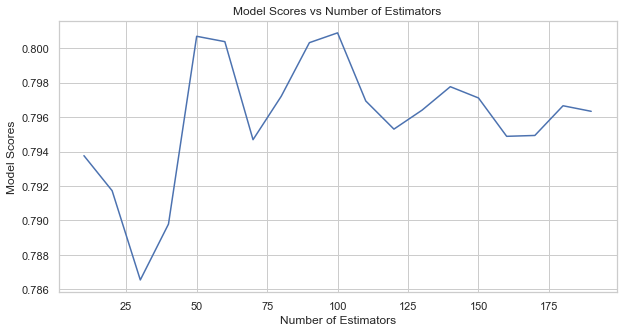

In [37]:
n_estimators = list(range(10, 200, 10))
model_scores = []

for i in n_estimators:
    model.set_params(n_estimators = i)
    model.fit(X_train, y_train)
    model_scores.append(model.score(X_test, y_test))
    
#Plot the graph    
plt.figure(figsize=(10, 5))
plt.title("Model Scores vs Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Model Scores")
plt.plot(n_estimators, model_scores)

This shows that 100 estimators will provide the highest score/accuracy for RandomForest with small variation if using estimators count is below or above 100. Similar accuracy is also obtained if 50 estimators are used.
- Accuracy with 100 estimators = 0.800892
- Accuracy with  50 estimators = 0.800692

Since the difference is very small, 50 estimators is the optimum hyperparameter value for Random Forest.

#### 3. XG Boosting Regressor

In [38]:
import xgboost as xgb
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train,y_train)
preds = model.predict(X_test)
model_with_scores.update(XG_Boosting = model.score(X_test, y_test))
model.score(X_test, y_test)

0.8241785576685662

XG Boost gives a slight better performance than Random Forest

### Model Comparison

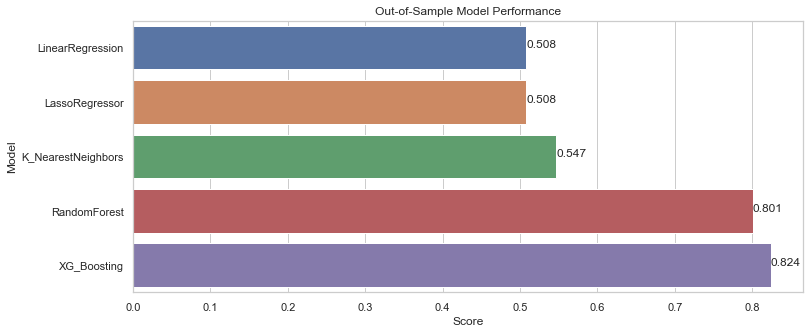

In [39]:
modelScores = pd.DataFrame(list(model_with_scores.items()), columns=['Model','Score'])

plt.figure(figsize=(12, 5))
plt.title("Out-of-Sample Model Performance")
for index, value in enumerate(round(modelScores['Score'],3)):
    plt.text(value, index, str(value))
sns.barplot(y='Model',x= 'Score', data=modelScores);

## Conclusion

The above graphs shows that XG Boosting has the best model score with a value of 0.824 or 82.4% . Random Forest is also not far behind which gives almost the same performance as XG Boost with a value of 0.801 or 80.1%. 

Thus the optimum model for predicting App Installs is XG Boost with a accuracy of 82.4%